# Official contours from case grids
Here we plot temp, u and v. 

streamlines to follow.


In [1]:
import os
import h5py
import numpy as np
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

from cmcrameri import cm
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import os
import h5py

# Define the data folder - must i nclude .h5 cas and dat files.
#data_folder = r"D:\2024 - Thermal Amplifiers - KC\Tr=1.1\Lauren\\"
#data_folder = r"E:\TR_1.0\\"
#data_folder = r"E:\L5\\"
grid_folder = "/Users/lila0720/lilahonours/AVERAGECONTOURS/"

#from cmcrameri import cm

In [2]:
data_folder = "/Volumes/ThermalAmp/TR1.8_new/"
case_files = [data_folder+f for f in os.listdir(data_folder) if f.endswith('.cas.post')]
case_files = [f for f in case_files if "/._" not in f]

fname = os.path.join(data_folder, case_files[0])

# Read the mesh data from the HDF5 file
with h5py.File(fname, 'r') as f:
    vertex_list = np.transpose(f['/meshes/1.post/nodes/coords/1'][:])

# Extract NodeX and NodeY
node_x = vertex_list[0]
node_y = vertex_list[1]

In [8]:
# DOMAIN PARAMETERS - only for plotting purposes.
Ypixels = 1080
XMIN    = -0.25
XMAX    = 0.25
YMIN    = -0.015
YMAX    = 0.085
AspectRatio     = (XMAX-XMIN)/(YMAX-YMIN)
Xpositions      = np.linspace(XMIN,XMAX,int(Ypixels*AspectRatio))
Ypositions      = np.linspace(YMAX,YMIN,Ypixels)
[xgrid,ygrid]   = np.meshgrid(Xpositions,Ypositions)
Clim = [300, 310]


def get_Qavg(SI):

    Tw = 308
    Height = 0.015
    CylinderDiameter = 0.01
    HeightOverDiamter = Height/CylinderDiameter

    Yw = -HeightOverDiamter*CylinderDiameter

    # Define the combined condition for masking
    mask_condition = (ygrid < Yw/1.02) & (xgrid < 0.2) & (xgrid > -0.2)
    y_ = np.unique(ygrid[ygrid <= -0.0147] )
    x_ = np.unique(xgrid[(xgrid < 0.2) & (xgrid > -0.2)])

    # Apply the mask to SI
    SI_masked = np.copy(SI)
    SI_masked[~mask_condition] = np.nan

    Y_ = np.unique(ygrid[ygrid <= Yw/1.02] )
    Y1 = Y_[-2]
    Y2 = Y_[-1]
    Y3 = Y1**2
    Y4 = Y2**2
    K_ThermalConductivity = 0.02225
    dTdy = []

    left_wall_ind = np.where(xgrid[-1] > -0.2)[0][0]
    right_wall_ind = np.where(xgrid[-1] > 0.2)[0][0]
    SI_slice = SI_masked[:, left_wall_ind:right_wall_ind]

    for c in range(SI_slice.shape[1]):
        T1 = SI_slice[-2, c]
        T2 = SI_slice[-1, c]
        dTdy_value = (T1 * Y4 - T2 * Y3 - Tw * (Y4 - Y3)) / (Y1 * Y4 - Y2 * Y3)
        dTdy.append(dTdy_value)
    Qavg = np.trapz(xgrid[-1][left_wall_ind:right_wall_ind], np.array(dTdy)*K_ThermalConductivity)
    return Qavg


def get_Qavg_line(SI):

    Tw = 308
    Height = 0.015
    CylinderDiameter = 0.01
    HeightOverDiamter = Height/CylinderDiameter

    Yw = -HeightOverDiamter*CylinderDiameter

    # Define the combined condition for masking
    mask_condition = (ygrid < Yw/1.02) & (xgrid < 0.2) & (xgrid > -0.2)
    y_ = np.unique(ygrid[ygrid <= -0.0147] )
    x_ = np.unique(xgrid[(xgrid < 0.2) & (xgrid > -0.2)])

    # Apply the mask to SI
    SI_masked = np.copy(SI)
    SI_masked[~mask_condition] = np.nan

    Y_ = np.unique(ygrid[ygrid <= Yw/1.02] )
    Y1 = Y_[-2]
    Y2 = Y_[-1]
    Y3 = Y1**2
    Y4 = Y2**2
    K_ThermalConductivity = 0.02225
    dTdy = []

    left_wall_ind = np.where(xgrid[-1] > -0.2)[0][0]
    right_wall_ind = np.where(xgrid[-1] > 0.2)[0][0]
    SI_slice = SI_masked[:, left_wall_ind:right_wall_ind]

    for c in range(SI_slice.shape[1]):
        T1 = SI_slice[-2, c]
        T2 = SI_slice[-1, c]
        dTdy_value = (T1 * Y4 - T2 * Y3 - Tw * (Y4 - Y3)) / (Y1 * Y4 - Y2 * Y3)
        dTdy.append(dTdy_value)
    
    return np.array(dTdy)*K_ThermalConductivity


In [9]:
cases = [1, 1.1, 1.2, 1.3, 1.4, 1.6, 1.8, 2, 2.7, 3.5]
Qs = []
All_si = []
All_usi = []
All_vsi = []

for case in cases:
    if os.path.isfile(grid_folder+"/Temp/Tr{}.h5".format(case)):
        print("y")
        with h5py.File(grid_folder+"/Temp/Tr{}.h5".format(case), 'r') as f:
            SI = f['T'][:]
            xpos = f['node_x'][:]
            ypos = f['node_y'][:]
    
            print(SI.max(), (SI.max()-298)/(308-298), get_Qavg(SI))
            Qs.append(get_Qavg(SI))

            All_si.append(SI)

    if os.path.isfile(grid_folder+"/U/Tr{}.h5".format(case)):
        with h5py.File(grid_folder+"/U/Tr{}.h5".format(case), 'r') as f:
            uSI = f['T'][:]
            xpos = f['node_x'][:]
            ypos = f['node_y'][:]
    
            print(SI.max(), (SI.max()-298)/(308-298)), #get_Qavg(uSI))
            #Qs.append(get_Qavg(uSI))

            All_usi.append(uSI)

    if os.path.isfile(grid_folder+"/V/Tr{}.h5".format(case)):
        with h5py.File(grid_folder+"/V/Tr{}.h5".format(case), 'r') as f:
            vSI = f['T'][:]
            xpos = f['node_x'][:]
            ypos = f['node_y'][:]
    
            print(SI.max(), (SI.max()-298)/(308-298)), #get_Qavg(uSI))
            #Qs.append(get_Qavg(uSI))

            All_vsi.append(vSI)
        
            
        #plt.imshow(SI)

y
308.00000000000006 1.0000000000000058 -18.137636771124434


/var/folders/ry/3sftjhts50x0vr1cmqhbw1z40000gp/T/ipykernel_37979/1505250309.py:49: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  Qavg = np.trapz(xgrid[-1][left_wall_ind:right_wall_ind], np.array(dTdy)*K_ThermalConductivity)


308.00000000000006 1.0000000000000058
308.00000000000006 1.0000000000000058
y
309.00000000000006 1.1000000000000056 -18.212940912546685
309.00000000000006 1.1000000000000056
309.00000000000006 1.1000000000000056
y
310.00000000000006 1.2000000000000057 -18.248925565479603
310.00000000000006 1.2000000000000057
310.00000000000006 1.2000000000000057
y
311.00000000000006 1.3000000000000056 -18.241618618860095
311.00000000000006 1.3000000000000056
311.00000000000006 1.3000000000000056
y
312.00000000000006 1.4000000000000057 -18.449391512552594
312.00000000000006 1.4000000000000057
312.00000000000006 1.4000000000000057
y
314.00000000000006 1.6000000000000056 -18.446824926002044
314.00000000000006 1.6000000000000056
314.00000000000006 1.6000000000000056
y
316.00000000000006 1.8000000000000056 -19.0682840636807
316.00000000000006 1.8000000000000056
316.00000000000006 1.8000000000000056
y
318.00000000000006 2.0000000000000058 -18.097150356981857
318.00000000000006 2.0000000000000058
318.00000000

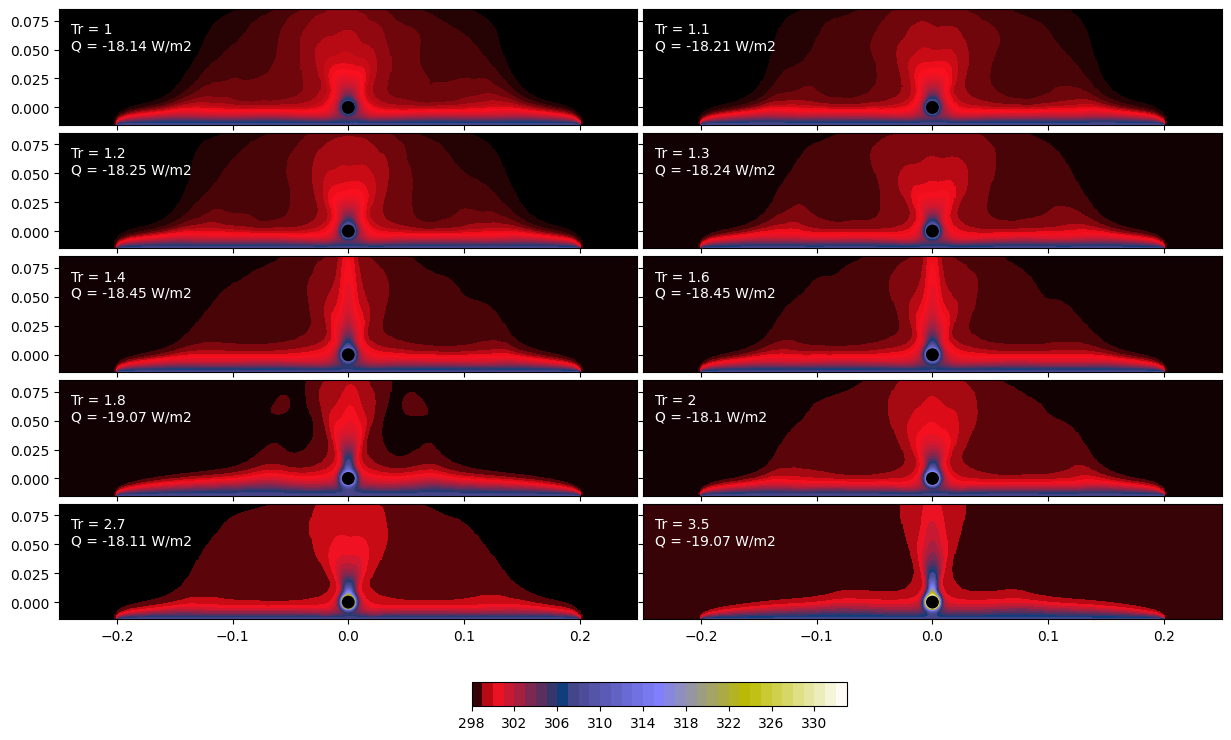

In [10]:
fig, axes = plt.subplots(5, 2, figsize=(15, 8))
axes = axes.ravel()  # Flatten the 2D array to 1D for easy indexing
fig.subplots_adjust(hspace=0.02, wspace=0.01)  # Adjust space between plots

for i, ax in enumerate(axes):

    #im = ax.imshow(All_si[i], cmap='turbo', vmin=298, vmax=325, extent=[XMIN, XMAX, YMIN, YMAX])
    im = ax.contourf(xgrid, ygrid, All_si[i], cmap='gist_stern', vmin=298, vmax=333, levels=40, extent=[XMIN, XMAX, YMIN, YMAX], origin='lower')
    #ax.set_title("Tr = {}, Q = {} W/m2".format(cases[i], round(Qs[i], 2)))
    ax.text(-0.24,0.05, "Tr = {} \nQ = {} W/m2".format(cases[i], round(Qs[i], 2)), color='w')
    ax.set_aspect('equal')
    circle = patches.Circle((0,0), radius=0.005, edgecolor='k', facecolor='k')
    ax.add_patch(circle)
    
    if i < 6:
        ax.set_xticklabels([])
    if i % 2 != 0:
        ax.set_yticklabels([])

cb_ax = fig.add_axes([0.4, 0.005, 0.25, 0.03])
plt.colorbar(im, cax=cb_ax, orientation='horizontal', shrink=0.8, extend='max')

#plt.savefig("./plot.pdf", bbox_inches='tight', dpi=500)

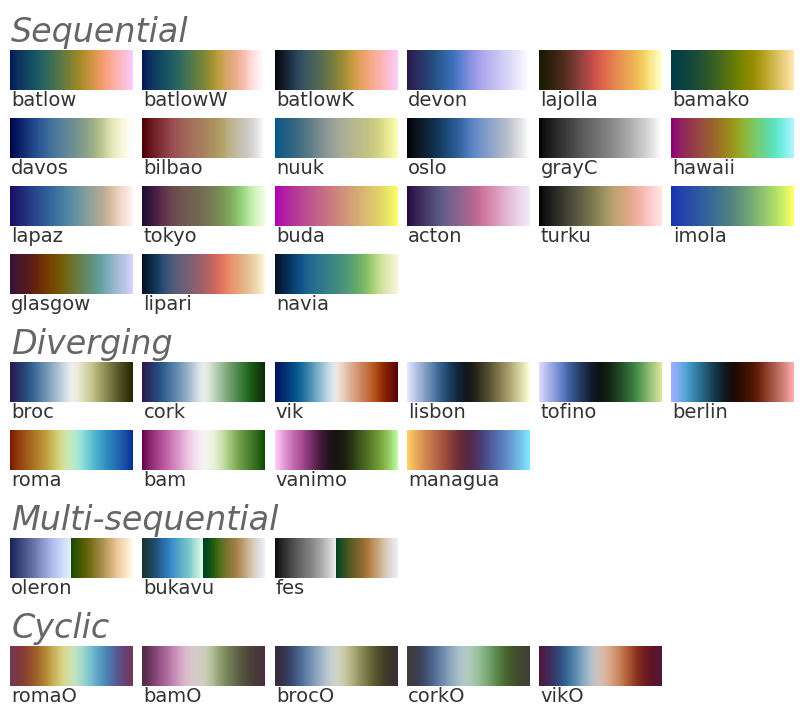

In [110]:
cm.show_cmaps()

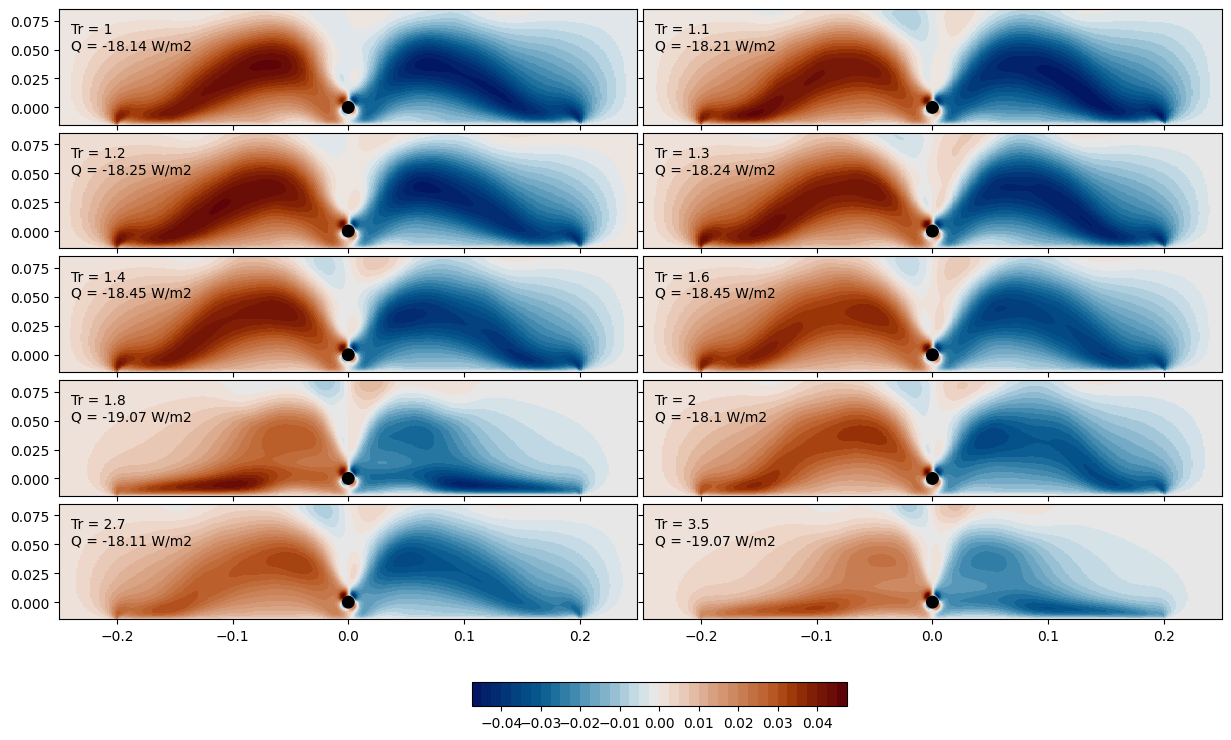

In [195]:
from matplotlib.colors import LinearSegmentedColormap

fig, axes = plt.subplots(5, 2, figsize=(15, 8))
axes = axes.ravel()  # Flatten the 2D array to 1D for easy indexing
fig.subplots_adjust(hspace=0.02, wspace=0.01)  # Adjust space between plots

for i, ax in enumerate(axes):

    #im = ax.imshow(All_si[i], cmap='turbo', vmin=298, vmax=325, extent=[XMIN, XMAX, YMIN, YMAX])
    im = ax.contourf(xgrid, ygrid, All_usi[i], cmap=cm.vik, levels=40, extent=[XMIN, XMAX, YMIN, YMAX])
    #ax.set_title("Tr = {}, Q = {} W/m2".format(cases[i], round(Qs[i], 2)))
    ax.text(-0.24,0.05, "Tr = {} \nQ = {} W/m2".format(cases[i], round(Qs[i], 2)), color='k')
    ax.set_aspect('equal')
    circle = patches.Circle((0,0), radius=0.005, edgecolor='k', facecolor='k')
    ax.add_patch(circle)
    
    if i < 6:
        ax.set_xticklabels([])
    if i % 2 != 0:
        ax.set_yticklabels([])

cb_ax = fig.add_axes([0.4, 0.005, 0.25, 0.03])
plt.colorbar(im, cax=cb_ax, orientation='horizontal', shrink=0.8, extend='max')

#plt.savefig("./plot.pdf", bbox_inches='tight', dpi=500)

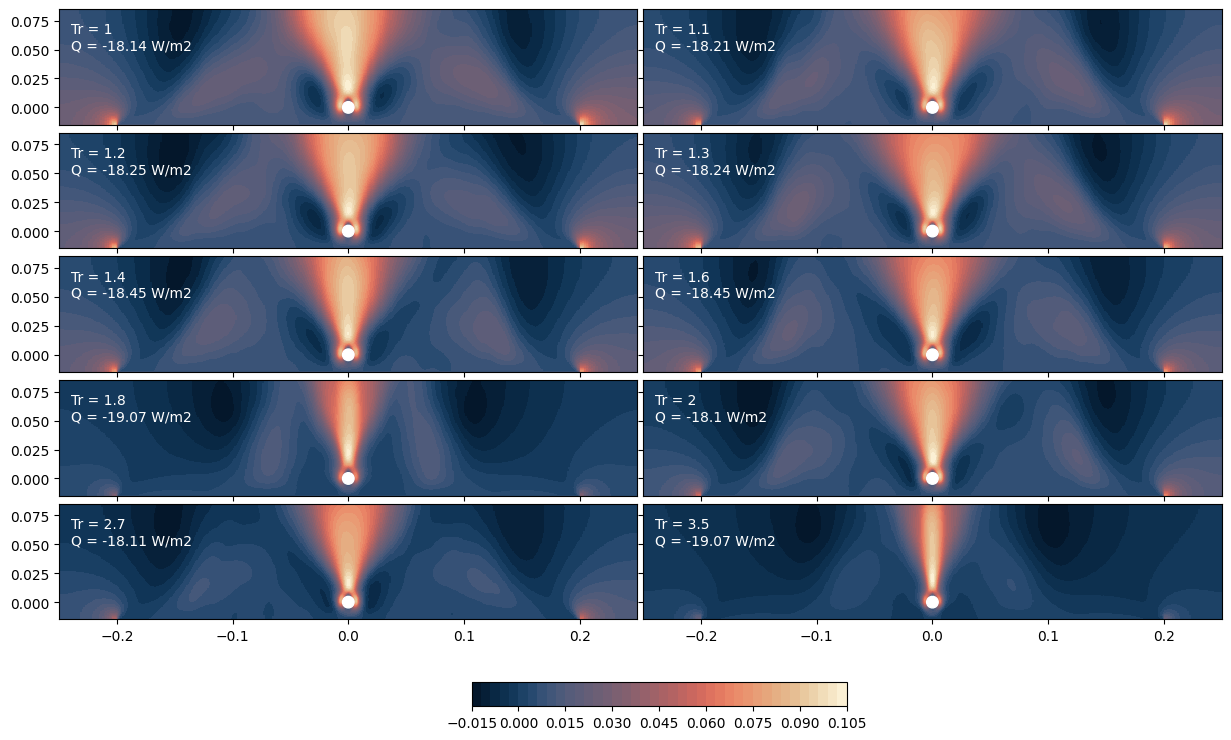

In [204]:
fig, axes = plt.subplots(5, 2, figsize=(15, 8))
axes = axes.ravel()  # Flatten the 2D array to 1D for easy indexing
fig.subplots_adjust(hspace=0.02, wspace=0.01)  # Adjust space between plots

for i, ax in enumerate(axes):
    

    #im = ax.imshow(All_si[i], cmap='turbo', vmin=298, vmax=325, extent=[XMIN, XMAX, YMIN, YMAX])
    im = ax.contourf(xgrid, ygrid, All_vsi[i], cmap=cm.lipari, levels=40, extent=[XMIN, XMAX, YMIN, YMAX])
    #ax.set_title("Tr = {}, Q = {} W/m2".format(cases[i], round(Qs[i], 2)))
    ax.text(-0.24,0.05, "Tr = {} \nQ = {} W/m2".format(cases[i], round(Qs[i], 2)), color='w')
    ax.set_aspect('equal')
    circle = patches.Circle((0,0), radius=0.005, edgecolor='w', facecolor='w')
    ax.add_patch(circle)
    
    if i < 6:
        ax.set_xticklabels([])
    if i % 2 != 0:
        ax.set_yticklabels([])

cb_ax = fig.add_axes([0.4, 0.005, 0.25, 0.03])
plt.colorbar(im, cax=cb_ax, orientation='horizontal', shrink=0.8, extend='max')

#plt.savefig("./plot.pdf", bbox_inches='tight', dpi=500)

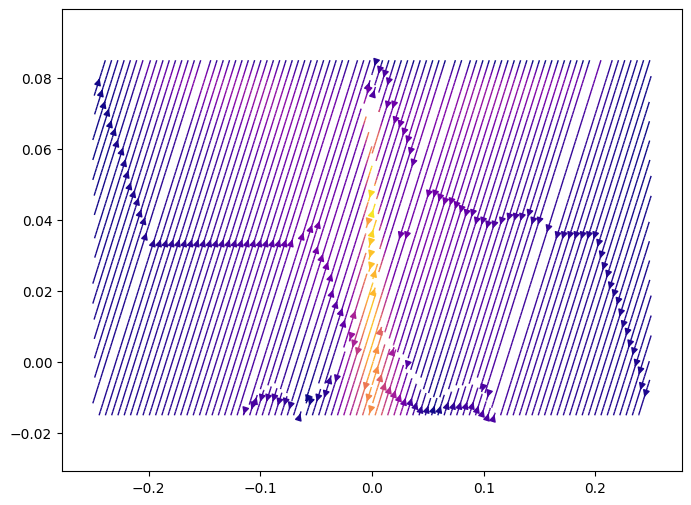

In [226]:
plt.figure(figsize=(8, 6))
plt.streamplot(np.sort(xgrid), np.sort(ygrid), All_usi[i], All_usi[i], color=np.sqrt(All_usi[i]**2 + All_vsi[i]**2), density=3, cmap='plasma', linewidth=1)


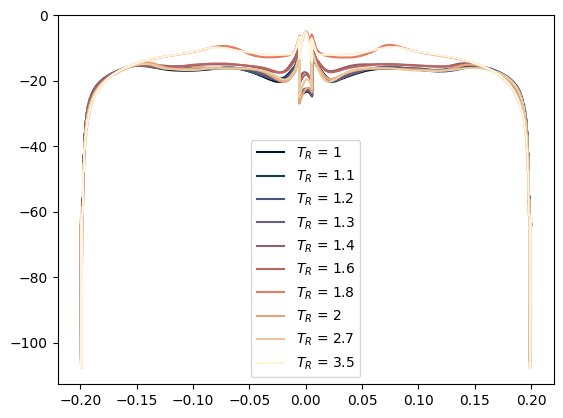

In [34]:
left_wall_ind = np.where(xgrid[-1] > -0.2)[0][0]
right_wall_ind = np.where(xgrid[-1] > 0.2)[0][0]

num_colors = 10
colormap = cm.lipari
colors = [colormap(i) for i in np.linspace(0, 1, num_colors)]

for i, SI in enumerate(All_si):
    Q_line = get_Qavg_line(SI)
    plt.plot(xgrid[-1][left_wall_ind:right_wall_ind], Q_line, color=colors[i], label="$T_R$ = {}".format(cases[i]))
plt.legend()

Text(0.5, 0, 'Wall length')

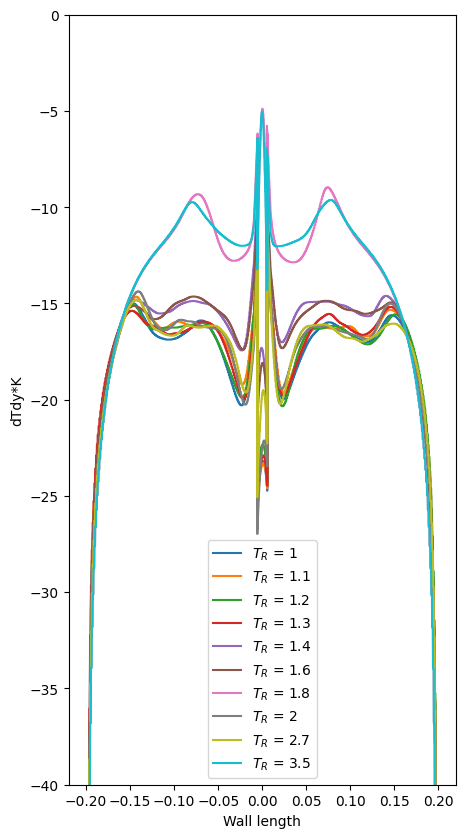

In [40]:
num_colors = 10
colormap = cm.lajolla
colors = [colormap(i) for i in np.linspace(0, 1, num_colors)]

fig, ax = plt.subplots(1, 1, figsize=(5, 10))
for i, SI in enumerate(All_si):
    Q_line = get_Qavg_line(SI)
    ax.plot(xgrid[-1][left_wall_ind:right_wall_ind], Q_line,  label="$T_R$ = {}".format(cases[i]))
ax.legend()
ax.set_ylim([-40,0])
#ax.set_aspect('equal')
ax.set_ylabel("dTdy*K")
ax.set_xlabel("Wall length")

Text(0, 0.5, 'Q')

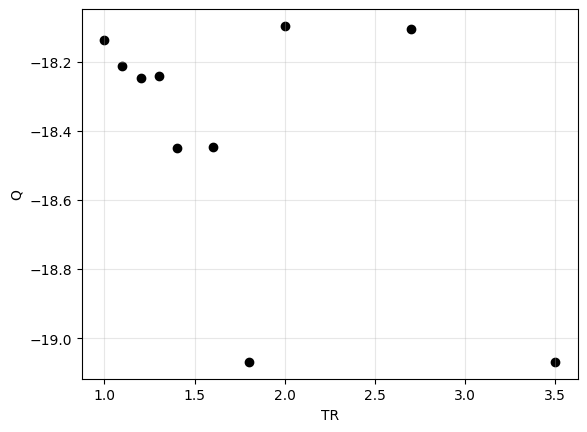

In [48]:
plt.scatter(cases, Qs, color='k')
plt.grid(alpha=0.3)
plt.xlabel("TR")
plt.ylabel("Q")